#0.필요 프로그램 설치

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install tensorflow tensorflow_text
!pip install gTTS
!pip install Pillow==9.0.0

#1.한글 폰트 설치

In [1]:
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
import matplotlib as plt


fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'


font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# 그래프에 retina display 적용

%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정

plt.rc('font', family='NanumBarunGothic') 

#2.메캅 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

#3.TextRank 구현

In [4]:
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np

class Mecab_sentence(object):

    def __init__(self, stopwords): 
        self.stopwords = stopwords
        self.mecab = Mecab()

    def nouns(self, sentences):
        nouns = []
        for sen in sentences:
            if sen != ' ' :
                nouns.append(" ".join([noun for noun in self.mecab.nouns(str(sen)) 
                                  if noun not in self.stopwords and len(noun) > 1]))
        return nouns


class G_matrix(object):

    def __init__(self):
        self.TF_IDF = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
  
    def sent_matrix(self, nouns):
        TF_IDF_MAT = self.TF_IDF.fit_transform(nouns).toarray()
        graph_sentence = np.dot(TF_IDF_MAT, TF_IDF_MAT.T)    # 용어 빈도와 역 문서 빈도와의 통계 곱
        return graph_sentence

    def word_matrix(self, nouns):
        CNT_VEC_MAT = normalize(self.cnt_vec.fit_transform(nouns).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(CNT_VEC_MAT.T, CNT_VEC_MAT), {vocab[word] : word for word in vocab}


class Rank(object):

    def get_ranks(self, graph, d=0.85):
        A = graph
        matrix_size = A.shape[0]            
        for idx in range(matrix_size):     
            A[idx, idx] = 0                  
            link_sum = np.sum(A[:, idx])     
            if link_sum != 0 :               
                A[:, idx] /= link_sum
            A[:, idx] *= -d
            A[idx, idx] = 1

        B = (1-d) * np.ones((matrix_size, 1)) 
        x = np.linalg.solve(A, B)          # 연립방정식 Ax = B
        return {idx : r[0] for idx, r in enumerate(x)}


class TextRank(object):
    def __init__(self, stopwords):
        super(TextRank, self).__init__()     
        self.sent_tokenize = Mecab_sentence(stopwords)
        self.matrix = G_matrix()
        self.rank = Rank()       

    def __call__(self, sentence, sentence_num=3):
        nouns = self.sent_tokenize.nouns(sentence)
        sent_graph = self.matrix.sent_matrix(nouns)
        word_graph, idx2word =  self.matrix.word_matrix(nouns)
        sent_rank_idx = self.rank.get_ranks(sent_graph)
        word_rank_idx = self.rank.get_ranks(word_graph)
        sorted_sent_rank_idx = sorted(sent_rank_idx, key=lambda k: sent_rank_idx[k], reverse=True)
        word_sent_rank_idx = sorted(word_rank_idx, key=lambda k: word_rank_idx[k], reverse=True)

        summary = []
        index = []
        for idx in sorted_sent_rank_idx[:sentence_num]:
            index.append(idx)

        index.sort()
        for idx in index:
            summary.append(sentence[idx])

    
        return [w for w in summary]


#4.파파고 API 구현

In [5]:
import os
import sys
import urllib.request

class papago_en_ko(object):
    def __init__(self, client_id, client_secret, data, url):
        super(papago_en_ko, self).__init__()
        self.client_id = client_id
        self.client_secret = client_secret
        self.data = url_data
        self.url = url
    
    def __call__(self, sentence):
        encText = urllib.parse.quote(sentence)
        enc_data = self.data + encText
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id",self.client_id)
        request.add_header("X-Naver-Client-Secret",self.client_secret)
        response = urllib.request.urlopen(request, data=enc_data.encode("utf-8"))
        rescode = response.getcode()
        
        if(rescode==200):
            response_body = response.read()
            result = response_body.decode('utf-8')
            result_list = result.split(":")
            translate_text = result_list[5]
            translate_text = str(translate_text)
            text_len = len(translate_text)
            text = translate_text[1:text_len-14]
            text = text.replace('\\', '')
            text = text.replace('" "', ' ')
            text = text.replace('"', '')

            return text

        else:
            print("Error Code:" + rescode)

#5.B.T.S 구현

In [23]:
import pytesseract 
import os
import random
try:
    from PIL import Image
except ImportError:
    import Image
import re
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw
import statistics
from google.colab.patches import cv2_imshow
from IPython.display import Audio 
from gtts import gTTS


class Extract_text(object):
    def __init__(self):
        super(Extract_text, self).__init__()
        self.string = pytesseract.image_to_string

    def __call__(self, src):
        ori_text = self.string(src, lang='eng')
        ori_text = ori_text.replace('because it is pa', 'because it is pain')
        ori_text = ori_text.replace('In\n\n', 'In ')
        ori_text = ori_text.replace('d0', 'do ')
        ori_text = ori_text.replace('\n\n', '¾')
        ori_text = ori_text.replace(' ¾', '')
        ori_text = ori_text.replace('\n', ' ')
        ori_text = ori_text.replace('|', 'I')
        ori_text = re.sub('[-=+#/\:;^$@*\※&ㆍ_『』\\‘|\(\)\[\]\<\>`\…》㎝「」]','', ori_text)
        ori_text = ori_text.split('¾')

        return ori_text

class Rectangle_Coordinates(object):
    def __init__(self, data):
        super(Rectangle_Coordinates, self).__init__()
        self.data = data
    
    def __call__(self, src):
        data = self.data(src)

        para_sep = 0
        x_mins, y_mins, x_maxs, y_maxs = [], [], [], []

        for idx, val in enumerate(data.splitlines()):
            if idx != 0 :
                if len(val.split()) == 11 :
                    para_sep += 1

                if para_sep >= 3 or para_sep == 1 or para_sep == 2 :
                    if len(val.split()) == 12:
                        para_sep = 0
                        x_mins.append(int(val.split()[6]))
                        y_mins.append(int(val.split()[7]))

                        x_maxs.append(int(data.splitlines()[idx - 1].split()[6]) + int(data.splitlines()[idx - 1].split()[8]))
                        y_maxs.append(int(data.splitlines()[idx - 1].split()[7]) + int(data.splitlines()[idx - 1].split()[9]))

        return x_mins, y_mins, x_maxs, y_maxs       


class Translate_text(object):
    def __init__(self, translate):
        super(Translate_text, self).__init__()
        self.translate = translate

    def __call__(self, ori_text):   
        kor_translate_text = [self.translate(w) for w in ori_text]
        # kor_translate_text = ['또는 내 즐겨찾기 중 일부를 선택하십시오.', '© 아이폰~', '로렘 아이폰 입숨', '로렘 아이폰 입숨. 아이폰 스마트폰 애플. 스티브 잡스 모바일 운영 체제 iOS 패널 화면 모델 업데이트. 사용자 인터페이스에는 앱 홈 스크린 앱 모델 접근성 기능 앱 스토어 사진이 있습니다. 전자 메일 프로그램은 방수 기능 네트워크 문자 메시지 WiFi 웹 실행을 레이아웃합니다. 영상 버튼 디자인 제스처 인식은 시장 스마트폰 앱 이코노미 사용자 앱스토어를 호출합니다. 화면크기는 세계 명품 시장 원 월드 뮤직 스마트폰 플랫폼이 기업들에게 이익을 준다. 스마트폰 모델들은 모바일 게임 체인저 슬레이트 폼팩터 안드로이드를 칭찬한다.']
        # kor_translate_text = ['로렘 입숨', '아마도 당신의 삶이 고통스러웠다면, 당신이 바라던 삶이 아니었을 것입니다', '"고통 그 자체를 사랑하는 사람, 단순히 고통이라는 이유만으로 고통을 찾고자 하는 사람은 없다"', '왜 우리가 그것을 사용하는가?', '로렘 입숨은 무엇인가?', 'Lorem Ipsum은 단순히 인쇄 및 조판 산업의 더미 텍스트입니다. 로렘 입숨은 1500년대 이후 업계의 표준 더미 텍스트로 자리 잡았는데, 그 때 한 알려지지 않은 프린터가 활자 견본 책을 만들기 위해 활자 갤리를 가져다가 스크램블했다. 그것은 5세기 동안 살아남았을 뿐만 아니라 본질적으로 변하지 않은 채로 전자 조판으로도 발전했다. 1960년대에 로렘 입숨 구절이 포함된 레트라셋 시트가 출시되면서 대중화되었으며, 최근에는 로렘 입숨 버전을 포함한 Aldus PageMaker와 같은 데스크톱 출판 소프트웨어로 대중화되었다.', '독자가 페이지의 레이아웃을 볼 때 읽을 수 있는 내용에 정신이 팔릴 것이라는 것은 오랫동안 확립된 사실이다. 로렘 입숨을 사용하는 포인트는 여기 내용, 여기 내용을 사용하는 것과 달리 글자가 무난히 정규적으로 분포되어 있어 읽기 쉬운 영어처럼 보인다는 것이다. 많은 데스크톱 출판 패키지 및 웹 페이지 편집자들은 현재 기본 모델 텍스트로 로렘 입숨을 사용하고 있으며, 로렘 입숨을 검색하면 초기 단계부터 많은 웹 사이트를 발견할 수 있다. 수년에 걸쳐 다양한 버전이 진화해 왔고, 때로는 우연히, 때로는 일부러 유머를 주입하기도 했다.']
        # kor_translate_text = ['킨들과 같은 디지털 독서 장치는 독자에게 제공되는 운동감각 및 촉각 피드백에 관해 종이책과 다르지만, 독서에서 이러한 기능의 역할은 경험적으로 연구된 적이 거의 없다. 이 실험은 킨들 DX와 인쇄물에서 긴 텍스트를 읽는 것을 비교합니다. 24세의 참가자 50명은 킨들이나 인쇄물 포켓북에서 28페이지 길이의 미스터리 스토리를 읽었고 다양한 수준의 독해력, 기억력, 본문의 사건들을 찾아내는 능력, 이야기의 줄거리를 재구성하는 여러 가지 테스트를 완료했다. 결과는 대부분의 테스트에서 피험자들이 읽기 매체가 무엇이든 동일하게 수행했다는 것을 보여주었다. 그러나 연대기와 일시성에 관한 측정에서는 인쇄물 포켓북에서 읽은 사람이 킨들로 읽었던 사람보다 더 잘했다. 기본적으로 이해력은 두 매체와 비슷하지만, 운동학적 피드백이 킨들에서는 덜 유익하기 때문에 독자들은 텍스트의 공간, 즉 이야기의 일시성에서 사건을 찾는 데 효율적이지 못했다. 우리는 텍스트의 정확한 공간적 표현과 결과적으로 이야기의 일관된 시간적 구성을 얻기 위해 독자들이 책의 조작에 의해 제공되는 감각 운동 단서에 의존할 것을 제안한다. 전반적으로, 서구 세계에서 독서는 점점 더 디지털화되고 있다. 킨들, 태블릿, 아이패드와 같은 휴대용 디지털 기기의 인기로 인해 롱폼 문어 읽기 또한 인쇄본보다는 스크린이 되고 있다. 이러한 전환은 내러티브, 문학 독서의 인지적, 정서적 측면에 대한 화면 디스플레이와 논문과 같은 기질적 어포던스의 역할과 관련된 많은 연구 질문을 불러온다. 주목할 만한 방법으로, 종이에서 화면으로의 이동은 독서가 인간공학 상호작용의 사례라는 것을 명백하게 만든다. 담화 처리의 보다 일반적으로 다루어지는 지각적, 인지적 구성 요소 외에도, 독서는 전형적으로 인쇄 포켓북, 전자책 또는 태블릿과 같은 장치와 수동적인 참여를 수반한다. 장치마다 사용자 인터페이스와 재료의 수용성이 다르며 인쇄 책자의 종이는 화면에 표시되는 텍스트와 다른 감각 운동 우발성을 제공한다. 인쇄된 텍스트는 물리적이고 접선적으로 매체와 인접한 반면, 디지털화된 텍스트는 매체와 물리적으로 분리될 수 있다. 이것은 디지털 장치가 많은 수의 텍스트와 다른 콘텐츠를 저장할 수 있게 한다. 그러나, 우리는 그러한 겉보기에는 미묘한 차이가 독서의 인지적, 경험적 애스핏과 상호작용할 수 있는 방법에 대해서는 거의 알지 못한다. 이론적인 일크의 독서 학자들은 어떻게 독서가 일반적으로 인정된 후각보다 더 다감각적인지 강조해 왔고, 시력은 독서에 있어서 가장 중요한 감각이라고 말한다. 그러나, 접촉은 아마도 가장 중요한 것일지도 모른다. 손에서 느껴지는 느낌, 종이의 냄새, 촉각적인 즐거움 화면을 조작하는 것은 읽는 습관을 강화하고 심화시킨다. 그리스 합티코스에서 온 광범위한 개념화, 촉각은 촉각을 의미한다. 따라서 수동 피부 촉각과 능동 자가수용 운동 감각 과정을 모두 포함한다. 연구 문헌에서, 햅틱, 힘 피드백, 운동 감각과 같은 용어들은 종종 번갈아 사용된다.']
        # kor_translate_text = ['본 코스에서 배울 내용', '신호 처리, 데이터 분석 및 이미지 필터링에서 현대 응용 분야에서 푸리에 변환이 어떻게 사용되는지에 초점을 맞춰 푸리에 변환의 이론적 및 계산 기반을 학습합니다. 이 과정에서는 기본 사항뿐만 아니라 비정상 효과, 스펙트럼 분해능, 정규화, 필터링을 포함한 고급 주제도 다룹니다. 모든 비디오에는 MATLAB 및 Python 코드가 함께 제공되므로 배우고 적응할 수 있습니다!', '이 과정은 컴퓨터에서의 푸리에 변환의 구현과 디지털 신호 처리 1D 및 이미지 처리 2D에서의 응용에 초점을 맞춥니다. 저는 분석적인 해결책을 얻기 위해 통합 문제를 설정하고 해결하는 것에 대해 자세히 설명하지 않습니다. 따라서, 이 과정은 순수 수학 미분 방정식 무한 급수 측면보다는 컴퓨터 과학 공학 측면에 더 가깝다.', '이 과정은 당신이 포부가 있거나 이미 확립된 경우 당신을 위한 것입니다.', '데이터 사이언티스트', '통계학자', '컴퓨터 과학자', '신호 처리 또는 이미지 처리 전문가 엔지니어', '생물학자', '학생', '호기심 많은 독자 학습자체 학습자 여러분!', '내가 이 과정을 가르칠 자격이 있는 이유', '저는 거의 20년 동안 주로 MATLAB에서 푸리에 변환을 연구 및 강의에 광범위하게 사용해 왔습니다. 저는 푸리에 변환에 광범위하게 의존하는 데이터 분석, 프로그래밍, 통계에 대한 여러 교재를 썼습니다. 가장 중요한 것은 푸리에 변환을 학사, 박사과정 학생, 교수, 전문가로 가르쳤고 생물학, 심리학, 물리학, 수학, 공학 등 다양한 배경의 사람들에게 가르쳤습니다.']             
        # kor_translate_text = ['저는', '로렘 실리콘 밸리 렙섬', '로렘 실리콘 밸리 입숨. 실리콘 밸리 샌프란시스코 베이 에어리어 기술 혁신 산호세 센터 북부 캘리포니아 산타클라라 밸리 도시들. 세계 실리콘 지역 기술 GDP 1인당 산호세 메트로폴리탄 지역 스타트업 기업들 세계 혁신자들. 지역 혁신 지역 기업들은 많은 미국 마이크로프로세서 마이크로컴퓨터 회로를 명명한다. 수천 개의 기업들이 모두 벤처 캐피털 투자 레드우드 시티 멘로 파크에서 워드 서킷 칩을 제조한다. MOS 트랜지스터는 홈 스타트업 생태계 허브 정보기술 종사자 서니베일 팔로 알토 마운틴 뷰 쿠퍼티노를 나타낸다. 컴퓨터 기술 정의 기업들은 본사 Synecdoche 섹터 동의어 기업 핫스팟을 명명한다. 세계 포춘 1000 취리히 오슬로 브루킹스 연구소 스위스 노르웨이 연구단지 기술센터 본부. 기업체들은 관광 연결 피플 샌마테오 카운티 산타클라라 카운티의 위치 조사 회사들을 구성합니다. 기간 도시 정의 1 오클랜드']
        
        return kor_translate_text


class Translate_text_split(object):
    def __init__(self):
        super(Translate_text_split, self).__init__()
        
    def __call__(self, kor_translate_text):
        summary_only = []
        for idx, val in enumerate(kor_translate_text):
            if len(val) > 170:
                split = val.split('. ')
                for j in split:
                    summary_only.append(j)

            else :        
                 summary_only.append(val) 

        return  summary_only 


class Text_data(object):
    def __init__(self, data):
        super(Text_data, self).__init__()
        self.data = data

    def __call__(self, src):
        data = self.data(src)

        para_sep = 0
        start_x, start_y, weidth, height = [], [], [], []
        font_size = []
        for idx, val in enumerate(data.splitlines()):
            if idx != 0 :
                if len(val.split()) == 11 :
                    para_sep += 1

                else:
                    if para_sep < 2:
                        para_sep = 0

                if para_sep >= 3 or para_sep == 2:
                    if len(val.split()) == 12:
                        para_sep = 0
                        start_x.append(int(val.split()[6]))
                        start_y.append(int(val.split()[7]))
                        weidth.append(int(data.splitlines()[idx - 1].split()[8]))
                        height.append(int(data.splitlines()[idx - 1].split()[9]))
                        font_size.append(int(val.split()[9])) 
        
        return start_x, start_y, weidth, height, font_size


class Translate_line_change(object):
    def __init__(self):
        super(Translate_line_change, self).__init__()


    def __call__(self, kor_translate_text, weidth, font_size):
        kor_puttext = []
        font_cnt = 0  

        for i in range(len(kor_translate_text)):
            kor_puttext.append([])

            font_cnt = 0    
            for w in kor_translate_text[i]:
                if w == ' ':
                    font_cnt += int(font_size[i] / 6)

                elif w == ('!' or '.' or ',' or '?'):
                    font_cnt += int(font_size[i] / 6)

                else:
                    font_cnt += font_size[i]  # 한글 폰트크기

                if font_size[i] <= 20:
                    if font_cnt >= weidth[i]:
                        w += '\n'
                        font_cnt = 0

                kor_puttext[-1].append(w)
        
        return kor_puttext


class Translate_pre_processing(object):
    def __init__(self):
        super(Translate_pre_processing, self).__init__()

    def __call__(self, kor_puttext, kor_translate_text):
        kor_translate_text_update = []
        for i in range(len(kor_puttext)):
            result = ''.join(s for s in kor_puttext[i])
            result = re.sub("\n ", "\n", result)
            result = re.sub("\n\n", "\n", result)

            if len(kor_translate_text[i]) >= 180:
                result = re.sub("\n", "\n\n", result)

            else:
                result = re.sub("\n\n\n", "\n", result)
                result = re.sub("\n\n", "\n", result)

            kor_translate_text_update.append(result)   

        return kor_translate_text_update


class BTS(object):
    def __init__(self, data, translate, stopwords):
        super(BTS, self).__init__()
        self.extract = Extract_text()
        self.rectangle = Rectangle_Coordinates(data)
        self.translate = Translate_text(translate)
        self.translate_split = Translate_text_split()        
        self.text_data = Text_data(data)        
        self.line_change = Translate_line_change()
        self.put_text = Translate_pre_processing()
        self.textrank = TextRank(stopwords)
        self.speech = gTTS

    def __call__(self, src, color, sentence_num=3):
        ori_text = self.extract(src)
        x_mins, y_mins, x_maxs, y_maxs = self.rectangle(src)
        kor_translate_text = self.translate(ori_text)
        summary_only = self.translate_split(kor_translate_text)
        start_x, start_y, weidth, height, font_size = self.text_data(src)
        kor_puttext = self.line_change(kor_translate_text, weidth, font_size)
        kor_translate_text_update = self.put_text(kor_puttext, kor_translate_text)
        summary = self.textrank(summary_only, sentence_num)
        

        for x_min, y_min, x_max, y_max in zip(x_mins, y_mins, x_maxs, y_maxs): 
             cv2.rectangle(src, (x_min-3, y_min-7), (x_max+20, y_max), color, -1)

        src1 = Image.fromarray(src)
        draw = ImageDraw.Draw(src1)

        for i in range(len(kor_translate_text_update)):       
            draw.text((int(start_x[i]), 
                       int(start_y[i])), 
                      kor_translate_text_update[i], 
                      spacing=5, 
                      font=ImageFont.truetype("NanumBarunGothic.ttf", font_size[i]), 
                      fill=(0, 0, 0))

        src_f = np.array(src1)
        # src_f = np.array(draw)

        str_kor_text = ''.join(kor_translate_text)
        eng_wav = self.speech(str_kor_text, lang ='ko')
    
        return src_f, summary, eng_wav


#6.매개변수 설정

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
with open('/content/drive/MyDrive/BTS/custom_stopwords.txt', 'r', encoding='utf-8') as f :
    stopwords = f.read().splitlines()  

# client_id = "4PUwE8MQTyF9CKWaJvCK" 
# client_secret = "uJow0P5yp3"   

client_id = "bUYlrevd998Ydb0GwUA6" 
client_secret = "MZWQBo9qPo"  

# client_id = "j0tkqzYjt5cizB_jUzBK" 
# client_secret = "OPPfQRAN1L"        

url_data = "source=en&target=ko&text="
url = "https://openapi.naver.com/v1/papago/n2mt"

translate = papago_en_ko(client_id, client_secret, url_data, url)

src = cv2.imread('/content/drive/MyDrive/BTS/2.png')

color = src[0, 0].tolist()
# color = [0, 248, 248]

data = pytesseract.image_to_data

#7.원본 이미지 출력

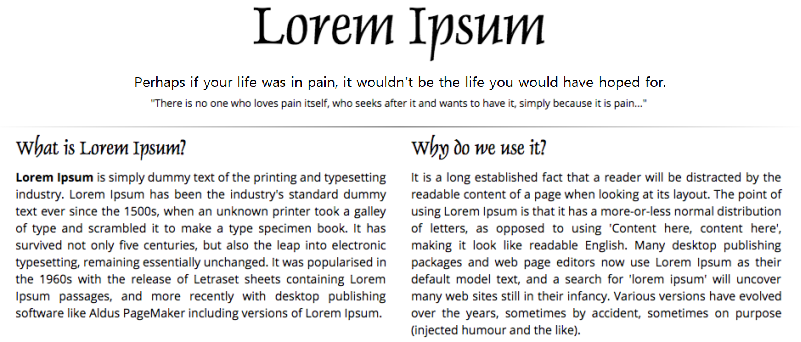

In [9]:
cv2_imshow(src)

#8.번역 이미지 출력 & 오디오 저장

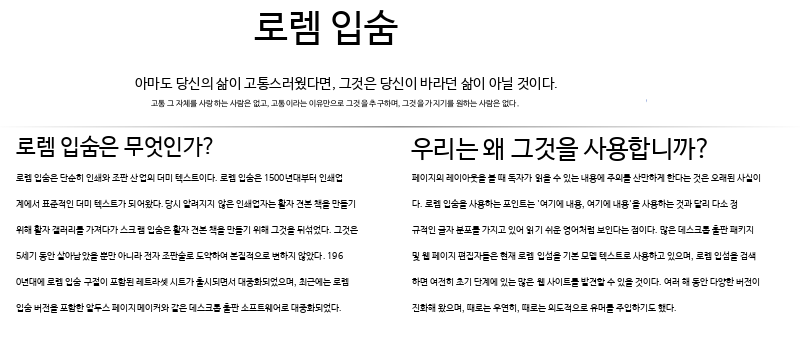

In [10]:
bts = BTS(data, translate, stopwords)

img, summary, kor_wav = bts(src, color)

cv2_imshow(img)

#9.번역 텍스트 음성 읽기

In [11]:
kor_wav.save('translation.wav')
display(Audio('translation.wav', autoplay=False))

#10.요약 출력

In [12]:
for idx, val in enumerate(summary) : 
    print(f'{idx+1}번째 핵심 문장 : {val}', '\n')

1번째 핵심 문장 : 로렘 입숨 

2번째 핵심 문장 : 로렘 입숨은 무엇인가? 

3번째 핵심 문장 : 로렘 입숨은 단순히 인쇄와 조판 산업의 더미 텍스트이다 

